1. Сформировать с помощью sklearn.make_classification датасет из 1000 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50, 100, 200 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote). Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.
2. (опция). Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.

In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [2]:
# сгенерируем данные
classes = datasets.make_classification(n_samples=1000, n_features=2, n_informative=2, 
                                                      n_classes=2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=13)

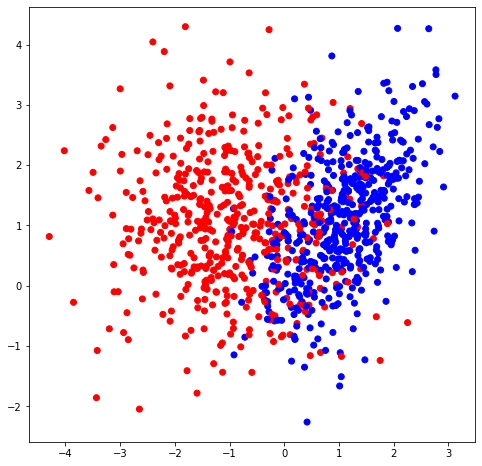

In [3]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classes[0])), list(map(lambda x: x[1], classes[0])), 
              c=classes[1], cmap=colors)

In [4]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [5]:
# И класс терминального узла (листа)

class Leaf:
    
    counter = 0
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        self.prediction_regressor = self.predict_regressor()
        type(self).counter += 1
        
    def predict_regressor(self):
        return np.mean(self.labels)
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [6]:
class DecisionTree():
    
    def __init__(self, max_depth=0, max_leaf=0, min_samples_leaf=1, criterion='gini'):
        self.max_depth = max_depth
        self.max_leaf = max_leaf
        self.min_samples_leaf = min_samples_leaf
        self.criterion = criterion
        
        
        
    # Расчет критерия Джини

    def gini(self, labels):
        #  подсчет количества объектов разных классов
        classes = {}
        for label in labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1

        #  расчет критерия
        impurity = 1
        for label in classes:
            p = classes[label] / len(labels)
            impurity -= p ** 2

        return impurity
    
    def entropy(self, labels):
        classes = np.unique(labels)
        entropy = -sum([((labels == classes[i]).sum() / len(labels)) * \
                  np.log2((labels == classes[i]).sum() / len(labels)) \
                  for i in range(len(classes))])
        return entropy
    
    def quality_entropy(self, left_labels, right_labels, current_entropy):
        p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
        return current_entropy - p * self.entropy(left_labels) - (1 - p) * self.entropy(right_labels)
    
    def quality(self, left_labels, right_labels, current_gini):

        # доля выбоки, ушедшая в левое поддерево
        p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

        return current_gini - p * self.gini(left_labels) - (1 - p) * self.gini(right_labels)
    
        # Разбиение датасета в узле

    def split(self, data, labels, index, t):

        left = np.where(data[:, index] <= t)
        right = np.where(data[:, index] > t)

        true_data = data[left]
        false_data = data[right]
        true_labels = labels[left]
        false_labels = labels[right]

        return true_data, false_data, true_labels, false_labels
    
#         # Построение дерева с помощью рекурсивной функции

    def build_tree(self, data, labels, ind=0):
        
        indx = ind
        indx +=1

        quality, t, index = self.find_best_split(data, labels)

        if len(labels) < self.min_samples_leaf * 2:
            return Leaf(data, labels)

        #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
        if quality == 0:
            return Leaf(data, labels)

        true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)
        
#         проверяем количество листьев в дереве:
        if Leaf.counter > self.max_leaf - 2:
            return Leaf(data, labels)
#         бывают расхождения по максимальному количеству листьев +- 2 штуки, как железно ограничить так и не смог придумать)
#         при долгих размышлениях я пришел к выводу, что использование
#         только этого критерия останова нецелесообразно или во всяком случае слишком малое его 
#         значение - можно не успеть выйти из первой рекурсии, а такой исход мне представляется
#         не очень веселым, т.к. у нас будет всего полдерева и при построении 
#         предикта алгоритм поломается сразу на корневом узле

        #  Проверяем глубину узла
        if indx == self.max_depth + 1:
            return Leaf(data, labels)

        # Рекурсивно строим два поддерева
        true_branch = self.build_tree(true_data, true_labels, indx)
        false_branch = self.build_tree(false_data, false_labels, indx)

        node = Node(index, t, true_branch, false_branch)
        # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
        return node
    
    def pred_object(self, obj, node):
#         print(node.index, 1, node.true_branch.index, 2, node.false_branch.index)

        #  Останавливаем рекурсию, если достигли листа
        if isinstance(node, Leaf):
            answer = node.prediction
            return answer
        i = node.index
        if obj[i] <= node.t:
            return self.pred_object(obj, node.true_branch)
        else:
            return self.pred_object(obj, node.false_branch)
        
    def predict(self, data, tree):

        pred = []
        for obj in data:
            prediction = self.pred_object(obj, tree)
            pred.append(prediction)
        return pred

In [7]:
class DecisionTreeClassifier(DecisionTree):
    
    # Расчет критерия Джини

    def gini(self, labels):
        #  подсчет количества объектов разных классов
        classes = {}
        for label in labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1

        #  расчет критерия
        impurity = 1
        for label in classes:
            p = classes[label] / len(labels)
            impurity -= p ** 2

        return impurity
    
    def entropy(self, labels):
        classes = np.unique(labels)
        entropy = -sum([((labels == classes[i]).sum() / len(labels)) * \
                  np.log2((labels == classes[i]).sum() / len(labels)) \
                  for i in range(len(classes))])
        return entropy
    
    def quality_entropy(self, left_labels, right_labels, current_entropy):
        p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
        return current_entropy - p * self.entropy(left_labels) - (1 - p) * self.entropy(right_labels)
    
    def quality(self, left_labels, right_labels, current_gini):

        # доля выбоки, ушедшая в левое поддерево
        p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

        return current_gini - p * self.gini(left_labels) - (1 - p) * self.gini(right_labels)
    
            # Нахождение наилучшего разбиения

    def find_best_split(self, data, labels):

        if self.criterion == 'gini':
            current_criterion = self.gini(labels)
        else:
            current_criterion = self.entropy(labels)

        best_quality = 0
        best_t = None
        best_index = None

        n_features = data.shape[1]

        for index in range(n_features):
            # будем проверять только уникальные значения признака, исключая повторения
            t_values = np.unique([row[index] for row in data])

            for t in t_values:
                true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)
                #  пропускаем разбиения, в которых в узле остается менее 5 объектов
                if len(true_data) < self.min_samples_leaf or len(false_data) < self.min_samples_leaf:
                    continue

                if self.criterion == 'gini':
                    current_quality = self.quality(true_labels, false_labels, current_criterion)
                else:
                    current_quality = self.quality_entropy(true_labels, false_labels, current_criterion)

                #  выбираем порог, на котором получается максимальный прирост качества
                if current_quality > best_quality:
                    best_quality, best_t, best_index = current_quality, t, index
#         print(best_index)
        return best_quality, best_t, best_index

In [8]:
class RandomForestClassifier(DecisionTreeClassifier):
    
    def __init__(self, max_depth=0, max_leaf=0, min_samples_leaf=1, criterion='gini', random_state=random.randint(0, 1000), target_class=1):
        super().__init__(max_depth, max_leaf, min_samples_leaf, criterion)
        random.seed(random_state)
        self.random_state = random_state
        self.target_class = target_class
    
    def random_forest(self, data, labels, n_trees):
        forest = []
        bootstrap = self.get_bootstrap(data, labels, n_trees)

        for b_data, b_labels in bootstrap:
            Leaf.counter = 0
            forest.append(self.build_tree(b_data, b_labels))

        return forest, bootstrap
    
    def out_of_bag(self, X_train, y_train, n_forest, bootstrap):
        obj_q = 0
        true_obj = 0
        for i in range(len(X_train)):
            trees = 0
            true = 0
            for ii in range(len(n_forest)):
                if np.all(bootstrap[ii][0] != X_train[i]):
                    trees += 1
                    tmp_tree = self.build_tree(bootstrap[ii][0], bootstrap[ii][1])
                    answer = self.predict(X_train[i]. reshape(1, 2), tmp_tree)
                    if answer == y_train[i]:
                        true += 1
                else:
                    continue
            if trees == 0:
                continue
            else:
                obj_q += 1
                if (true / trees) > 0.5:
                    true_obj += 1
        return true_obj / obj_q

    # предсказание голосованием деревьев

    def tree_vote(self, data, labels, forest, plot=False):

        # добавим предсказания всех деревьев в список
        predictions = []
        for tree in forest:
            predictions.append(self.predict(data, tree))

        # сформируем список с предсказаниями для каждого объекта
        predictions_per_object = list(zip(*predictions))

        # выберем в качестве итогового предсказания для каждого объекта то,
        # за которое проголосовало большинство деревьев
        voted_predictions = []
        for obj in predictions_per_object:
            voted_predictions.append(max(set(obj), key=obj.count))

        if plot == False:
            self.calc_accuracy(np.array(voted_predictions), labels)
    #             self.calc_precision(answers, self.y_test)
    #             self.calc_recall(answers, self.y_test)
            self.calc_f_score(np.array(voted_predictions), labels)
        return voted_predictions
    
    
 
    def get_bootstrap(self, data, labels, N):
        random.seed(self.random_state)
        n_samples = data.shape[0]
        bootstrap = []

        for i in range(N):
            b_data = np.zeros(data.shape)
            b_labels = np.zeros(labels.shape)
            for j in range(n_samples):
                sample_index = random.randint(0, n_samples-1)
                b_data[j] = data[sample_index]
                b_labels[j] = labels[sample_index]            
            bootstrap.append((b_data, b_labels))

        return bootstrap
   
    def get_subsample(self, len_sample):
        # будем сохранять не сами признаки, а их индексы
        sample_indexes = [i for i in range(len_sample)]

        len_subsample = int(np.sqrt(len_sample))
        subsample = []

        random.shuffle(sample_indexes)
        for _ in range(len_subsample):
            subsample.append(sample_indexes.pop())

        return subsample

    def find_best_split(self, data, labels):

        if self.criterion == 'gini':
            current_criterion = self.gini(labels)
        else:
            current_criterion = self.entropy(labels)

        best_quality = 0
        best_t = None
        best_index = None

        n_features = data.shape[1]

        subsample = self.get_subsample(n_features)
    
        for index in subsample:
            # будем проверять только уникальные значения признака, исключая повторения
            t_values = np.unique([row[index] for row in data])

            for t in t_values:
                true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)
                #  пропускаем разбиения, в которых в узле остается менее 5 объектов
                if len(true_data) < self.min_samples_leaf or len(false_data) < self.min_samples_leaf:
                    continue

                if self.criterion == 'gini':
                    current_quality = self.quality(true_labels, false_labels, current_criterion)
                else:
                    current_quality = self.quality_entropy(true_labels, false_labels, current_criterion)

                #  выбираем порог, на котором получается максимальный прирост качества
                if current_quality > best_quality:
                    best_quality, best_t, best_index = current_quality, t, index
#         print(best_index)
        return best_quality, best_t, best_index

    def calc_accuracy(self,y_pred, y):
        accuracy = 100.0 - np.mean(np.abs(y_pred - y)*100.0)
        print(f'Accuracy: {accuracy}')
        
        return accuracy
    
    
    def matrix_err(self,y_pred, y):
        tp = np.count_nonzero((y_pred == y) & (y_pred == self.target_class))
        tn = np.count_nonzero((y_pred == y) & (y_pred != self.target_class))
        fp = np.count_nonzero((y_pred != y) & (y_pred == self.target_class))
        fn = np.count_nonzero((y_pred != y) & (y_pred != self.target_class))
        print('TP     FP\nFN     TN')
        print(np.array([[tp, fp], [fn, tn]]))
        
        return tp, tn, fp, fn
    
    
    def calc_precision(self,y_pred, y):
        tp, tn, fp, fn = self.matrix_err(y_pred, y)
        precision = tp / (tp + fp)
        print(f'Precision: {precision}')
        
        return precision
    
    
    def calc_recall(self,y_pred, y):
        tp, tn, fp, fn = self.matrix_err(y_pred, y)
        recall = tp / (tp + fn)
        print(f'Recall: {recall}')
        
        return recall
    
    
    def calc_f_score(self,y_pred, y, beta=1):
        tp, tn, fp, fn = self.matrix_err(y_pred, y)
        precision = self.calc_precision(y_pred, y)
        recall = self.calc_recall(y_pred, y)
        f_score = (1 + beta ** 2) * (precision * recall) / (beta ** 2 * precision + recall)
        print(f'F-score: {f_score}')
        return f_score

In [9]:
def train_test_split(data, proportion=0.7):
    # перемешивание датасета
    np.random.seed(12)
    shuffle_index = np.random.permutation(data[0].shape[0])
    X_shuffled, y_shuffled = data[0][shuffle_index], data[1][shuffle_index]

    # разбивка на обучающую и тестовую выборки
    train_proportion = proportion
    train_test_cut = int(len(data[0]) * train_proportion)

    X_train, X_test, y_train, y_test = \
        X_shuffled[:train_test_cut], \
        X_shuffled[train_test_cut:], \
        y_shuffled[:train_test_cut], \
        y_shuffled[train_test_cut:]
    list_array = [X_train, X_test, y_train, y_test]
    
#     X_train, X_test, y_train, y_test = transpose(list_array)

    print("Размер массива признаков обучающей выборки", X_train.shape)
    print("Размер массива признаков тестовой выборки", X_test.shape)
    print("Размер массива ответов для обучающей выборки", y_train.shape)
    print("Размер массива ответов для тестовой выборки", y_test.shape)
    
    return X_train, X_test, y_train, y_test

In [10]:
X_train, X_test, y_train, y_test = train_test_split(classes)

Размер массива признаков обучающей выборки (700, 2)
Размер массива признаков тестовой выборки (300, 2)
Размер массива ответов для обучающей выборки (700,)
Размер массива ответов для тестовой выборки (300,)


In [11]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [12]:
forest = RandomForestClassifier(max_depth=5, min_samples_leaf=10, max_leaf=30, random_state=13)

In [13]:
forest_1, bootstrap = forest.random_forest(X_train, y_train, 5)

In [14]:
train_pred = forest.tree_vote(X_train, y_train, forest_1)
test_pred = forest.tree_vote(X_test, y_test, forest_1)

Accuracy: 87.57142857142857
TP     FP
FN     TN
[[318  60]
 [ 27 295]]
TP     FP
FN     TN
[[318  60]
 [ 27 295]]
Precision: 0.8412698412698413
TP     FP
FN     TN
[[318  60]
 [ 27 295]]
Recall: 0.9217391304347826
F-score: 0.8796680497925311
Accuracy: 85.0
TP     FP
FN     TN
[[135  27]
 [ 18 120]]
TP     FP
FN     TN
[[135  27]
 [ 18 120]]
Precision: 0.8333333333333334
TP     FP
FN     TN
[[135  27]
 [ 18 120]]
Recall: 0.8823529411764706
F-score: 0.8571428571428571


In [15]:
train_accuracy = accuracy_metric(y_train, train_pred)
print(train_accuracy)
test_accuracy = accuracy_metric(y_test, test_pred)
print(test_accuracy)

87.57142857142857
85.0


In [16]:
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

def plot(X_train, y_train, X_test, y_test, n_forest, n):
    print(f'Лес из {n} деревьев')
    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(X_train)
    mesh_predictions = np.array(forest.tree_vote(np.c_[xx.ravel(), yy.ravel()], y_train, n_forest, plot=True)).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(X_train[:, 0], X_train[:, 1], c = y_train, cmap = colors)
    plt.title(f'Train accuracy={accuracy_metric(y_train, forest.tree_vote(X_train, y_train, n_forest, plot=True)):.2f}', fontsize=18)

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(X_test[:, 0], X_test[:, 1], c = y_test, cmap = colors)
    plt.title(f'Test accuracy={accuracy_metric(y_test, forest.tree_vote(X_test, y_test, n_forest, plot=True)):.2f}', fontsize=18)
    plt.show()

In [17]:
n_list = [1, 3, 10, 50, 100, 200]

Лес из 1 деревьев


<ipython-input-16-a46d8a7cfadf>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
<ipython-input-16-a46d8a7cfadf>:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)


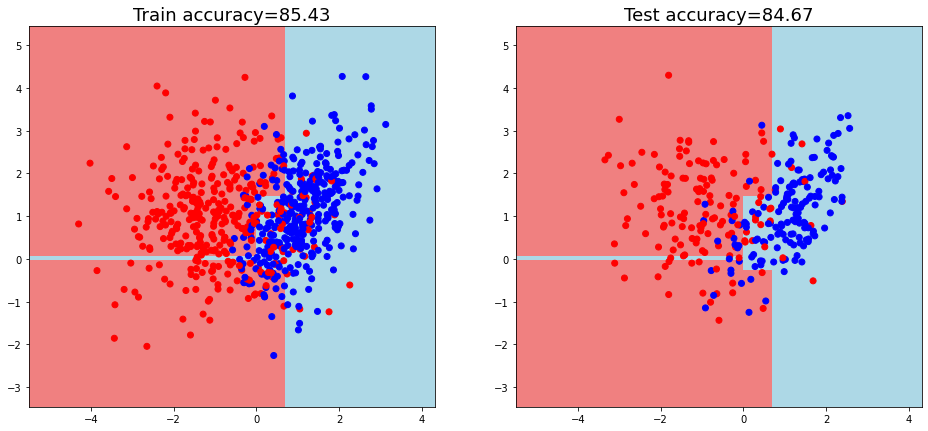

Лес из 3 деревьев


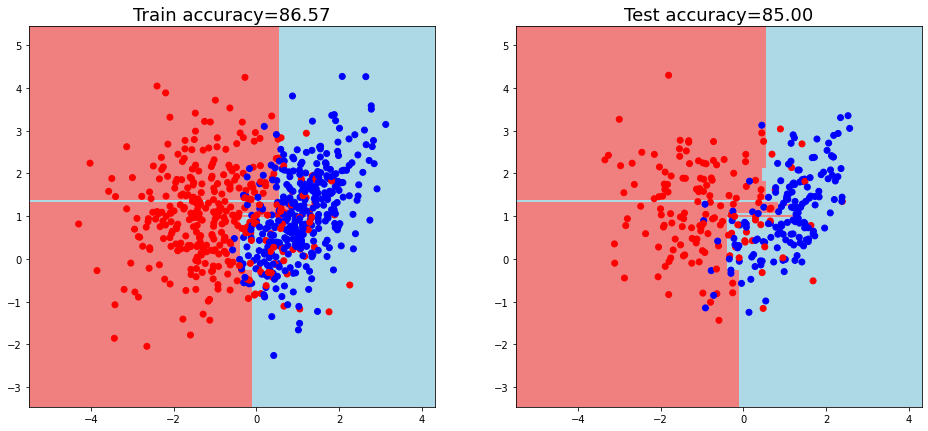

Лес из 10 деревьев


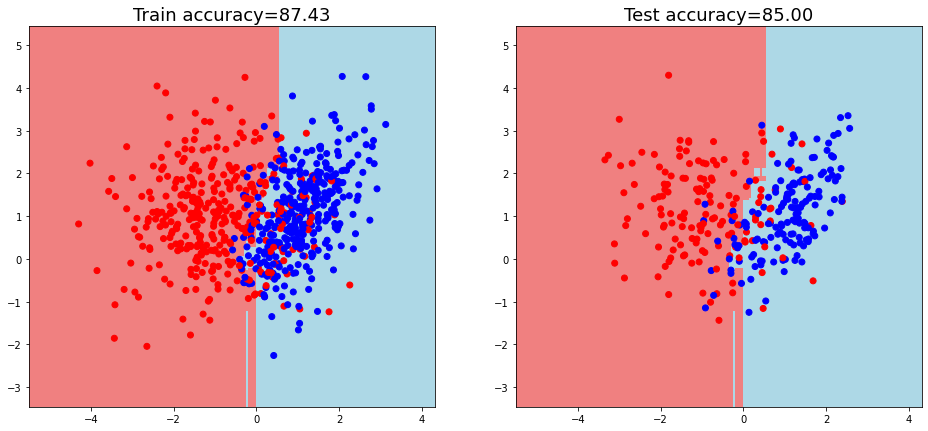

Лес из 50 деревьев


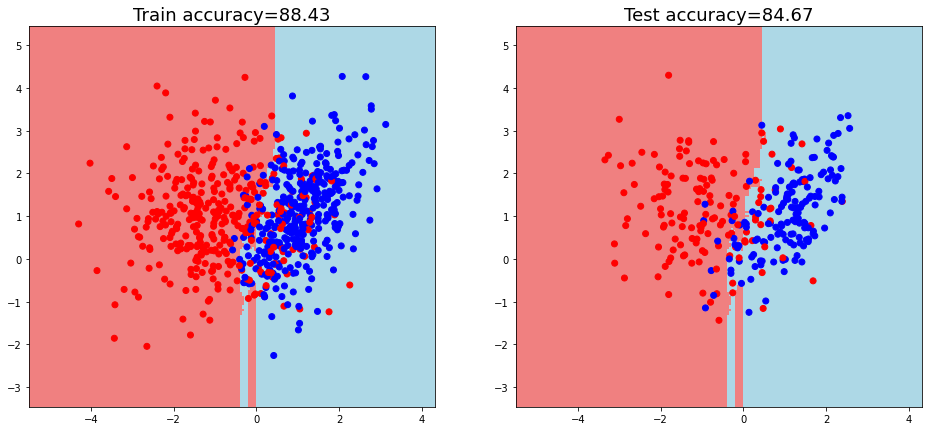

Лес из 100 деревьев


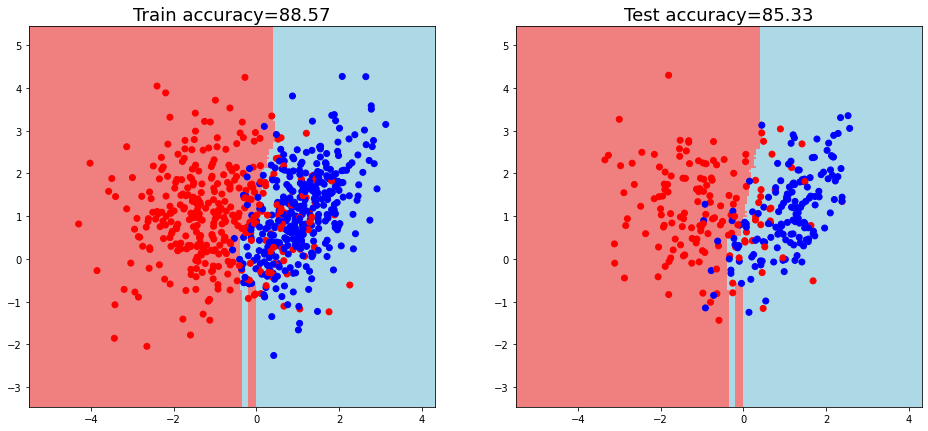

Лес из 200 деревьев


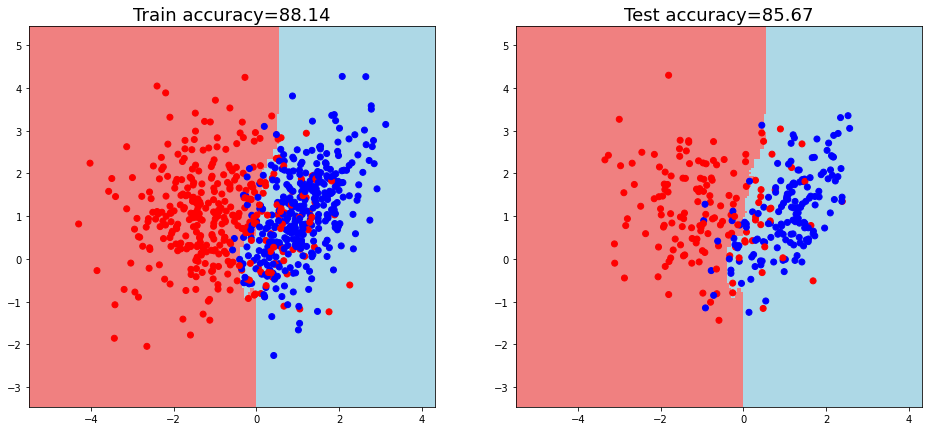

In [18]:
for n in n_list:
    forest_n, bootstrap_n = forest.random_forest(X_train, y_train, n)
    plot(X_train, y_train, X_test, y_test, forest_n, n)
    

С увеличением кол-ва деревьев в ансамбле сложность гиперплоскости растет (хотя и базовое дерево задано не самое слабое)) точность на трейне растет постоянно при увеличении ансамбля, а вот на тесте после 50 деревьев происходит небольшая просадка. с выбранными гиперпараметрами и метрикой лучшим вариантом является ансамбль из 50 деревьев.

In [19]:
for n in n_list:
    forest_n, bootstrap_n = forest.random_forest(X_train, y_train, n)
    z = forest.out_of_bag(X_train, y_train, forest_n, bootstrap_n)
    print(f'OOB на ансамбле из {n} деревьев: {z}')
    train_pred = forest.tree_vote(X_train, y_train, forest_n)
#     plot(X_train, y_train, X_test, y_test, forest_n, n)

OOB на ансамбле из 1 деревьев: 0.49236641221374045
Accuracy: 85.42857142857143
TP     FP
FN     TN
[[295  52]
 [ 50 303]]
TP     FP
FN     TN
[[295  52]
 [ 50 303]]
Precision: 0.8501440922190202
TP     FP
FN     TN
[[295  52]
 [ 50 303]]
Recall: 0.855072463768116
F-score: 0.8526011560693642
OOB на ансамбле из 3 деревьев: 0.37209302325581395
Accuracy: 86.57142857142857
TP     FP
FN     TN
[[310  59]
 [ 35 296]]
TP     FP
FN     TN
[[310  59]
 [ 35 296]]
Precision: 0.8401084010840109
TP     FP
FN     TN
[[310  59]
 [ 35 296]]
Recall: 0.8985507246376812
F-score: 0.8683473389355744
OOB на ансамбле из 10 деревьев: 0.38583815028901736
Accuracy: 87.42857142857143
TP     FP
FN     TN
[[318  61]
 [ 27 294]]
TP     FP
FN     TN
[[318  61]
 [ 27 294]]
Precision: 0.8390501319261213
TP     FP
FN     TN
[[318  61]
 [ 27 294]]
Recall: 0.9217391304347826
F-score: 0.8784530386740331
OOB на ансамбле из 50 деревьев: 0.5014285714285714
Accuracy: 88.42857142857143
TP     FP
FN     TN
[[329  65]
 [ 16 290]]

такое ощущение, что я сделал что-то не так в реализации OOB - уж очень подозрительно низкое значение получается (я думал будет что-то близкое к общим метрикам - а тут провал)